Problem 1.1

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

np.set_printoptions(precision=6, suppress=True)

# ====== Use your absolute dataset path ======
CSV_PATH = Path("/Users/mao/Vscode Projects/Duke_ECE_685D_intro_to_DL/HW1/Concrete_Data_Yeh.csv")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

print(f"Using CSV: {CSV_PATH}")

# ====== Load data ======
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)
print("Columns:", list(df.columns))

# ====== Identify features and target (target is 'csMPa' in your file) ======
target_col = "csMPa"
if target_col not in df.columns:
    # Be forgiving with case differences
    lower_map = {c.lower(): c for c in df.columns}
    if "csmpa" in lower_map:
        target_col = lower_map["csmpa"]
    else:
        raise KeyError(f"Target column 'csMPa' not found. Current columns: {list(df.columns)}")

feature_cols = [c for c in df.columns if c != target_col]

print("Target column:", target_col)
print(f"Feature columns (expect 8): {feature_cols} (count: {len(feature_cols)})")

# ====== Build X (with bias) and Y ======
X_raw = df[feature_cols].to_numpy(dtype=float)   # shape: (N, 8)
Y = df[[target_col]].to_numpy(dtype=float)       # shape: (N, 1)

N, m = X_raw.shape
X = np.hstack([np.ones((N, 1)), X_raw])          # shape: (N, 9) => bias + 8 features
print("X shape (with bias):", X.shape, "Y shape:", Y.shape)

# ====== Closed-form solution: β̂ = (X^T X)^(-1) X^T Y ======
XT = X.T
XTX = XT @ X

try:
    XTX_inv = np.linalg.inv(XTX)   # per assignment: explicit inverse
except np.linalg.LinAlgError:
    print("Warning: X^T X is singular/ill-conditioned; using pseudo-inverse for stability.")
    XTX_inv = np.linalg.pinv(XTX)

beta_hat = XTX_inv @ (XT @ Y)      # shape: (9, 1)

# ====== Show coefficients ======
coef_names = ["bias"] + feature_cols
coef_values = beta_hat.flatten()

coef_df = pd.DataFrame({"term": coef_names, "beta_hat": coef_values})
print("\n=== Coefficients (β̂) ===")
print(coef_df.to_string(index=False))

# ====== In-sample MSE on full dataset (for Q1.1) ======
Y_pred = X @ beta_hat
mse = np.mean((Y - Y_pred) ** 2)
print(f"\nIn-sample MSE (full data, 9 params): {float(mse):.6f}")

Using CSV: /Users/mao/Vscode Projects/Duke_ECE_685D_intro_to_DL/HW1/Concrete_Data_Yeh.csv
Data shape: (1030, 9)
Columns: ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age', 'csMPa']
Target column: csMPa
Feature columns (expect 8): ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age'] (count: 8)
X shape (with bias): (1030, 9) Y shape: (1030, 1)

=== Coefficients (β̂) ===
            term   beta_hat
            bias -23.331214
          cement   0.119804
            slag   0.103866
          flyash   0.087934
           water  -0.149918
superplasticizer   0.292225
 coarseaggregate   0.018086
   fineaggregate   0.020190
             age   0.114222

In-sample MSE (full data, 9 params): 107.197236


Problem 1.2

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

np.set_printoptions(precision=6, suppress=True)

# ====== Load dataset ======
CSV_PATH = Path("/Users/mao/Vscode Projects/Duke_ECE_685D_intro_to_DL/HW1/Concrete_Data_Yeh.csv")
df = pd.read_csv(CSV_PATH)

target_col = "csMPa"
feature_cols = [c for c in df.columns if c != target_col]

X_raw = df[feature_cols].to_numpy(dtype=float)
Y = df[[target_col]].to_numpy(dtype=float)

N, m = X_raw.shape
print("Dataset:", X_raw.shape, Y.shape)

# ====== Train/validation split ======
np.random.seed(42)  # for reproducibility
indices = np.random.permutation(N)
train_size = int(0.75 * N)

train_idx, val_idx = indices[:train_size], indices[train_size:]
X_train_raw, Y_train = X_raw[train_idx], Y[train_idx]
X_val_raw, Y_val = X_raw[val_idx], Y[val_idx]

print("Train size:", X_train_raw.shape[0], "Val size:", X_val_raw.shape[0])

# ====== Helper functions ======
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def fit_closed_form(X, Y):
    XT = X.T
    XTX = XT @ X
    try:
        XTX_inv = np.linalg.inv(XTX)
    except np.linalg.LinAlgError:
        XTX_inv = np.linalg.pinv(XTX)
    return XTX_inv @ (XT @ Y)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# ====== Try different feature subsets ======
results = {}

# Case 1: all 8 features (9 params with bias)
X_train = add_bias(X_train_raw)
X_val = add_bias(X_val_raw)
beta9 = fit_closed_form(X_train, Y_train)
Y_val_pred = X_val @ beta9
results["9 features"] = mse(Y_val, Y_val_pred)

# Case 2: drop 1 feature (try dropping 'flyash' for example)
drop1 = ["flyash"]
features8 = [f for f in feature_cols if f not in drop1]
X_train8 = add_bias(X_train_raw[:, [feature_cols.index(f) for f in features8]])
X_val8 = add_bias(X_val_raw[:, [feature_cols.index(f) for f in features8]])
beta8 = fit_closed_form(X_train8, Y_train)
Y_val_pred8 = X_val8 @ beta8
results["8 features (drop flyash)"] = mse(Y_val, Y_val_pred8)

# Case 3: drop 2 features (e.g., 'flyash' and 'slag')
drop2 = ["flyash", "slag"]
features7 = [f for f in feature_cols if f not in drop2]
X_train7 = add_bias(X_train_raw[:, [feature_cols.index(f) for f in features7]])
X_val7 = add_bias(X_val_raw[:, [feature_cols.index(f) for f in features7]])
beta7 = fit_closed_form(X_train7, Y_train)
Y_val_pred7 = X_val7 @ beta7
results["7 features (drop flyash+slag)"] = mse(Y_val, Y_val_pred7)

# ====== Print results ======
print("\n=== Validation MSE results ===")
for k, v in results.items():
    print(f"{k:30s}: {v:.4f}")

Dataset: (1030, 8) (1030, 1)
Train size: 772 Val size: 258

=== Validation MSE results ===
9 features                    : 103.9674
8 features (drop flyash)      : 104.3792
7 features (drop flyash+slag) : 114.9011


Problem 2

Train features: torch.Size([54000, 256]), Val: torch.Size([6000, 256]), Test: torch.Size([10000, 256])
Epoch 01 | TrainLoss=0.1469 | ValLoss=0.0467 | TrainAcc=0.9950 | ValAcc=0.9940
Epoch 05 | TrainLoss=0.0181 | ValLoss=0.0171 | TrainAcc=0.9986 | ValAcc=0.9988
Epoch 10 | TrainLoss=0.0111 | ValLoss=0.0110 | TrainAcc=0.9992 | ValAcc=0.9993
Epoch 15 | TrainLoss=0.0083 | ValLoss=0.0085 | TrainAcc=0.9996 | ValAcc=0.9997
Epoch 20 | TrainLoss=0.0067 | ValLoss=0.0070 | TrainAcc=0.9997 | ValAcc=0.9997
Epoch 25 | TrainLoss=0.0057 | ValLoss=0.0061 | TrainAcc=0.9998 | ValAcc=0.9997
Epoch 30 | TrainLoss=0.0050 | ValLoss=0.0054 | TrainAcc=0.9998 | ValAcc=0.9997


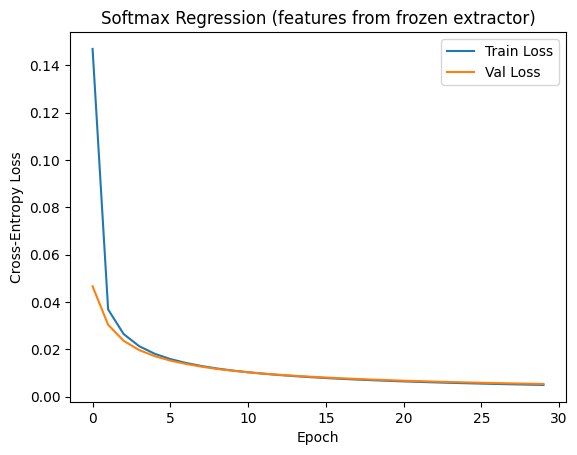

Test Accuracy: 0.9907


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# 1) Your pre-trained extractor
# ---------------------------
class extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,5,1,2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(), nn.MaxPool2d(2)
        )
        self.dim_redu = nn.Sequential(nn.Linear(32*7*7,256), nn.Tanh())

    def forward(self, x):
        N,C,W,H = x.shape
        assert C == 1 and W == 28 and H == 28, 'input tensor should be N×1×28×28'
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # (N, 32*7*7)
        return self.dim_redu(x)     # (N, 256)

# ---------------------------
# 2) Config
# ---------------------------
DEVICE = "cpu"  # keep CPU unless told otherwise
BATCH = 512
VAL_SPLIT = 0.1             # 10% of train used as validation
LR = 0.1
EPOCHS = 30
NUM_CLASSES = 10
FEATURE_DIM = 256
FEATURE_WEIGHTS_PATH = Path("feature_extractor_weights.pth")
# ---------------------------
# 3) Data: MNIST
# ---------------------------
tfm = transforms.Compose([transforms.ToTensor()])
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

# Split train into train/val
num_train = len(train_full)
num_val = int(num_train * VAL_SPLIT)
num_train_eff = num_train - num_val
train_set, val_set = torch.utils.data.random_split(train_full, [num_train_eff, num_val], generator=torch.Generator().manual_seed(42))

train_loader_img = torch.utils.data.DataLoader(train_set, batch_size=BATCH, shuffle=False)
val_loader_img   = torch.utils.data.DataLoader(val_set,   batch_size=BATCH, shuffle=False)
test_loader_img  = torch.utils.data.DataLoader(test_set,  batch_size=BATCH, shuffle=False)

# ---------------------------
# 4) Load extractor + weights & freeze
# ---------------------------
feat = extractor().to(DEVICE)
if not FEATURE_WEIGHTS_PATH.exists():
    raise FileNotFoundError(f"Pretrained weights not found: {FEATURE_WEIGHTS_PATH.resolve()}")
state = torch.load(FEATURE_WEIGHTS_PATH, map_location=DEVICE)
# Accept either plain state_dict or wrapped
feat.load_state_dict(state if isinstance(state, dict) else state['state_dict'])
feat.eval()
for p in feat.parameters():
    p.requires_grad = False

# ---------------------------
# 5) Extract latent features h for all splits
# ---------------------------
def extract_features(dataloader):
    H_list, y_list = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            h = feat(x)                     # (N, 256)
            H_list.append(h.cpu())
            y_list.append(y)
    H = torch.cat(H_list, dim=0)            # (N_total, 256)
    y = torch.cat(y_list, dim=0).long()     # (N_total,)
    return H, y

H_train, y_train = extract_features(train_loader_img)
H_val,   y_val   = extract_features(val_loader_img)
H_test,  y_test  = extract_features(test_loader_img)

N_tr = H_train.shape[0]
print(f"Train features: {H_train.shape}, Val: {H_val.shape}, Test: {H_test.shape}")

# ---------------------------
# 6) Softmax regression from scratch (matrix ops)
# ---------------------------
# Parameters
torch.manual_seed(0)
W = torch.zeros((FEATURE_DIM, NUM_CLASSES), dtype=torch.float32)  # (k, C)
b = torch.zeros((1, NUM_CLASSES), dtype=torch.float32)            # (1, C)

# Helper functions (no autograd)
def softmax(logits):
    # logits: (N, C)
    z = logits - logits.max(dim=1, keepdim=True).values
    expz = torch.exp(z)
    return expz / expz.sum(dim=1, keepdim=True)

def one_hot(y, C):
    return F.one_hot(y, num_classes=C).float()

def ce_loss(probs, y_oh):
    # probs, y_oh: (N, C)
    return -(y_oh * (probs.clamp_min(1e-12)).log()).sum(dim=1).mean()

def accuracy(probs, y):
    pred = probs.argmax(dim=1)
    return (pred == y).float().mean().item()

# Mini-batch indexer over feature tensors (no image dataloader needed now)
def batch_iter(H, y, batch):
    N = H.shape[0]
    idx = torch.randperm(N)
    for i in range(0, N, batch):
        j = idx[i:i+batch]
        yield H[j], y[j]

train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    # ---- Train epoch (manual SGD) ----
    epoch_loss = 0.0
    count = 0
    for Hb, yb in batch_iter(H_train, y_train, BATCH):
        # forward
        logits = Hb @ W + b                 # (B, C)
        probs  = softmax(logits)            # (B, C)
        y_oh   = one_hot(yb, NUM_CLASSES)   # (B, C)
        loss   = ce_loss(probs, y_oh)
        epoch_loss += loss.item() * Hb.size(0)
        count += Hb.size(0)

        # gradients (matrix calculus; no autograd)
        # grad_logits = (probs - y_oh) / B
        grad_logits = (probs - y_oh) / Hb.size(0)          # (B, C)
        dW = Hb.T @ grad_logits                            # (k, C)
        db = grad_logits.sum(dim=0, keepdim=True)          # (1, C)

        # SGD update
        W -= LR * dW
        b -= LR * db

    train_losses.append(epoch_loss / count)

    # ---- Validation ----
    with torch.no_grad():
        val_logits = H_val @ W + b
        val_probs  = softmax(val_logits)
        yv_oh      = one_hot(y_val, NUM_CLASSES)
        vloss      = ce_loss(val_probs, yv_oh).item()
        val_losses.append(vloss)
        if epoch % 5 == 0 or epoch == 1:
            tr_logits = H_train @ W + b
            tr_probs  = softmax(tr_logits)
            tr_acc    = accuracy(tr_probs, y_train)
            va_acc    = accuracy(val_probs, y_val)
            print(f"Epoch {epoch:02d} | TrainLoss={train_losses[-1]:.4f} | ValLoss={vloss:.4f} | "
                  f"TrainAcc={tr_acc:.4f} | ValAcc={va_acc:.4f}")

# ---------------------------
# 7) Plot losses
# ---------------------------
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Softmax Regression (features from frozen extractor)")
plt.show()

# ---------------------------
# 8) Final test accuracy (optional)
# ---------------------------
with torch.no_grad():
    test_logits = H_test @ W + b
    test_probs  = softmax(test_logits)
    test_acc    = accuracy(test_probs, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Problem 3

Z1 mean=-0.0007, var=1.0017
Z2 mean=-0.0006, var=1.0042
corr(Z1,Z2)=0.0004


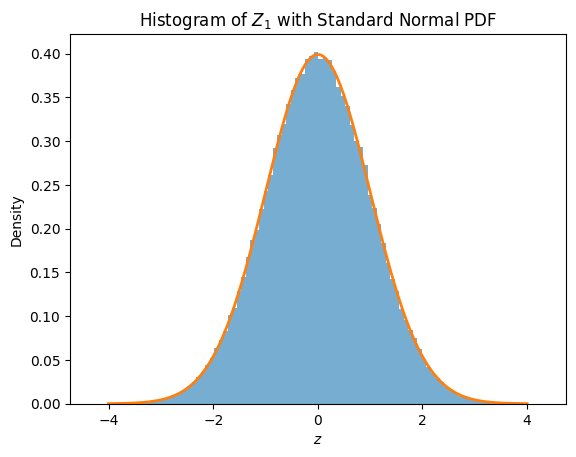

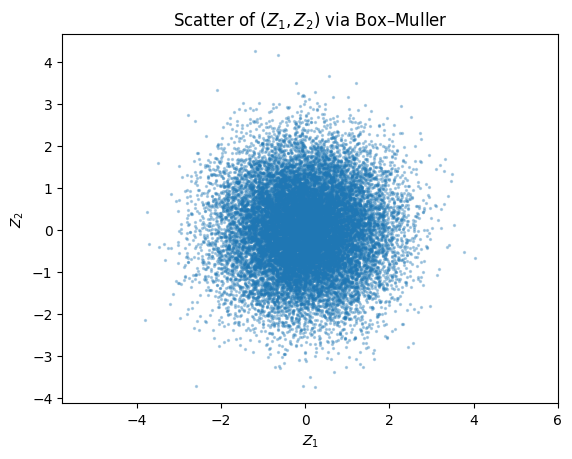

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1) Generate uniforms and transform
n = 200_000
U1 = np.random.rand(n)
U2 = np.random.rand(n)

Theta = 2 * np.pi * U1
R = np.sqrt(-2.0 * np.log(U2))

Z1 = R * np.cos(Theta)
Z2 = R * np.sin(Theta)

# 2) Quick sanity: means, vars, correlation
print(f"Z1 mean={Z1.mean():.4f}, var={Z1.var():.4f}")
print(f"Z2 mean={Z2.mean():.4f}, var={Z2.var():.4f}")
print(f"corr(Z1,Z2)={np.corrcoef(Z1, Z2)[0,1]:.4f}")

# 3) Histogram vs. N(0,1) pdf (Z1)
plt.figure()
x = np.linspace(-4, 4, 400)
plt.hist(Z1, bins=100, density=True, alpha=0.6)
plt.plot(x, norm.pdf(x), linewidth=2)
plt.title("Histogram of $Z_1$ with Standard Normal PDF")
plt.xlabel("$z$")
plt.ylabel("Density")
plt.show()

# 4) Scatter to visualize independence / circular symmetry
plt.figure()
plt.scatter(Z1[:20000], Z2[:20000], s=2, alpha=0.3)
plt.title("Scatter of $(Z_1, Z_2)$ via Box–Muller")
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.axis("equal")
plt.show()